# ***Muziek classificeren***

|Teamleden|Kaggle Username|GitHub Username|
|--|--|--|
|Busse Heemskerk|bussejheemskerk|BJHeemskerk|
|Declan van den Hoek|declanvdh|DeclanvandenHoek|
|Isa Dijkstra|isadijkstra|IsaD01|

In dit notebook gaan we kleine muziek samples classificeren met behulp van unsupervised learning. Een deel van deze bestand heeft een genre label, terwijl de meeste dit niet zullen hebben. Aan ons is de taak om zo accuraat mogelijk te bepalen welke genres de unlabeled samples hebben, door middel van Unsupervised Learning.

Voor het project hebben we gewerkt in [GitHub](https://github.com/BJHeemskerk/MachineLearning/tree/main/Muziek), om makkelijk de bestanden te delen. Van elk model zijn de voorspellingen ook geupload naar [Kaggle](https://www.kaggle.com/competitions/muziek-genre-clustering/overview).

## **Libaries en data inladen** <a name='h1'></a>

In [2]:
import os
import librosa as lr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from librosa.core import stft
from librosa.core import amplitude_to_db
import librosa.feature as lf
from librosa.feature import spectral_bandwidth, spectral_centroid
import librosa
import librosa.display
import IPython.display as ipd

# Om audio af te kunnen spelen
from IPython.display import Audio

from sklearn.cluster import KMeans

In de onderstaande cel, die gebaseerd is op de code van het Machine Learning notebook uit week 11, wordt de data ingelezen en in een dataframe gezet.

In [3]:
def mfccs(data, sfreq):
    """
    Bereken Mel Frequency Cepstral Coefficients
    (MFCCs) voor het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.

    sfreq : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    datadict : dict
        Een dictionary met gemiddelde waarden
        van MFCCs per coëfficiënt.
    """
    # Toepassen van mfcc via librosa
    mfcc = lr.feature.mfcc(y=data, sr=sfreq)
    datadict = {}

    # Vullen van datadict
    for var in range(len(mfcc)):
        datadict[f'mfcc{var + 1}_mean'] = np.mean(mfcc[var, :])

    return datadict

def calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
    """
    Bereken het spectrogram voor elk audiofragment in de audio_clips-reeks.

    Parameters:
    ----------
    audio_clips : lijst
        Een lijst met audioclips (numpy-arrays).
    n_fft : int, optioneel
        Het aantal datapunten dat wordt gebruikt in elk blok voor de FFT (standaard 2048).
    hop_length : int, optioneel
        Het aantal samples tussen opeenvolgende frames (standaard 512).
    win_length : int, optioneel
        De venstergrootte (standaard is `n_fft`).

    Returns:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen die overeenkomen met elk audioclip.
    spec_db : array
        De spectrogrammen in decibels, voor het plotten.
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:

        # Calculate the STFT. Use lr.stft() here.
        stft_matrix = stft(y=clip,
                           n_fft=n_fft,
                           hop_length=hop_length,
                           win_length=win_length)

        # Calculate the magnitude of the STFT (spectrogram). Use np.abs() here.
        spectrogram = np.abs(stft_matrix)

        # Convert to decibels. Use amplitude_to_db() here.
        spec_db = amplitude_to_db(S=spectrogram,
                                  ref=np.max)

        # Append the spectrogram to the list
        spectrograms.append(spectrogram)

        # Append spectrogram in decibels to the list
        spectrograms_db.append(spec_db)

    return spectrograms, spectrograms_db


def calculate_spectral_features(spectrograms):
    """
    Bereken de centroid en bandbreedte voor elk spectrogram in een lijst.

    Parameters:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen.

    Returns:
    ----------
    bandwidths : lijst
        Een lijst met bandbreedtes die overeenkomen met elk spectrogram.
    centroids : lijst
        Een lijst met centroids die overeenkomen met elk spectrogram.
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Calculate the bandwidth for the spectrogram (use lr.feature.spectral_bandwidth)
        spec_bw = spectral_bandwidth(S=spectrogram)

        # Calculate the spectral centroid for the spectrogram (use lr.feature.spectral_centroid)
        spec_cn = spectral_centroid(S=spectrogram)

        # Append the spectral bandwidth to the list
        bandwidths.append(spec_bw)

        # Append the spectral centroid to the list
        centroids.append(spec_cn)

    return bandwidths, centroids

def calculate_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
    """
    Bereken spectrale contrasten van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_contrast : array
        Spectrale contrasten.
    """
    spectral_contrast = lf.spectral_contrast(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)

    return spectral_contrast

def calculate_tonnetz(data, sr):
    """
    Bereken de tonnetz-functies van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    tonnetz : array
        Tonnetz-functies.
    """
    tonnetz = lf.tonnetz(y=data, sr=sr)

    return tonnetz

def calculate_spectral_rolloff(data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
    """
    Bereken de spectrale rolloff van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    roll_percent : float, optioneel
        Percentage van de spectrale energie waar de rolloff wordt berekend (standaard 0.85).
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_rolloff : array
        Spectrale rolloff.
    """
    spectral_rolloff = lf.spectral_rolloff(y=data, sr=sr, roll_percent=roll_percent, n_fft=n_fft, hop_length=hop_length)

    return spectral_rolloff

In [4]:
def rms_energy_features(data):
    # Compute RMS Energy
    rms_energy = lf.rms(y=data)

    return rms_energy

In [5]:
def chroma_features(data, sfreq):
    # Compute Chroma feature
    chroma = lf.chroma_stft(y=data, sr=sfreq)

    datadict = {}

    # Fill datadict
    for var in range(len(chroma)):
        datadict[f'chroma{var + 1}_mean'] = np.mean(chroma[var, :])

    return datadict

In [6]:
def zero_crossing_rate_features(data):
    # Compute Zero Crossing Rate (ZCR)
    zcr = lf.zero_crossing_rate(y=data)

    return zcr

In [7]:
def calculate_beat(audio_clips, sfreq):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    
    beat = []
    temp = []

    for clip in audio_clips:

        tempo, beats = librosa.beat.beat_track(y=clip, sr=sfreq)

        beat.append(beats)
        temp.append(tempo)
    
    return beat, temp

In [8]:
def calculate_harmonie(audio_clips):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """

    harmonie = []

    for clip in audio_clips:

        harmonic, _ = librosa.effects.hpss(y=clip)

        harmonie.append(harmonic)
        
    return harmonie

Nu de functies en features zijn uitgelegd en opgezet, kan de data ingeladen worden samen met de features.

In [9]:
# Load labeled data from CSV
labeled_data = pd.read_csv("labels_new.csv", sep=',')
labeled_data = labeled_data.sort_values('filename')

def load_music(directory):
    # Aanmaken lists voor data
    audio_data = []
    sample_freqs = []
    mfcc_data = {}
    chroma_data = {}

    # Lengte is 30 sec op 22050Hz
    lengte = 30 * 22050

    # Process each audio file
    for file in os.listdir(directory):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            data, sfreq = lr.load(file_path, sr=None)

            # Truncate or pad the audio
            if len(data) > lengte:
                # Truncate the data
                data = data[:lengte]
            elif len(data) < lengte:
                # Pad with zeros
                padding = lengte - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Append the processed data and label
            audio_data.append(data)
            sample_freqs.append(sfreq)

            # Aanmaken van de MFCC en de Chroma
            mfcc_dict = mfccs(data, sfreq)
            chroma_dict = chroma_features(data, sfreq)

            # Update the dictionary with individual MFCC coefficients
            for key, value in mfcc_dict.items():
                if key not in mfcc_data:
                    mfcc_data[key] = []
                mfcc_data[key].append(value)

            # Updaten van de chroma dictionary
            for key, value in chroma_dict.items():
                if key not in chroma_data:
                    chroma_data[key] = []
                chroma_data[key].append(value)

    # Convert to numpy array
    audio_data = np.stack(audio_data, axis=0)
    sample_freqs = np.array(sample_freqs)

    # Create a DataFrame from the processed audio data
    df = pd.DataFrame({
        'filename': os.listdir(directory),
        'data': audio_data.tolist(),
        'Hz': sample_freqs.tolist(),
    })

    # Add columns for each MFCC coefficient
    for key, values in mfcc_data.items():
        df[key] = values
    
    # Toevoegen van chroma features
    for key, values in chroma_data.items():
        df[key] = values

    # Merge the labeled_data DataFrame with the audio_df DataFrame based on the 'filename' column
    if directory == "labeled":
        df = labeled_data.merge(df, how='left', on='filename')

    # Calculate spectrograms
    spectrograms, spectrograms_db = calculate_spectrograms(audio_data, n_fft=2048, hop_length=512, win_length=None)
    bandwidths, centroids = calculate_spectral_features(spectrograms)
    spectral_contrast = calculate_spectral_contrast(audio_data, sfreq, n_fft=2048, hop_length=512)
    tonnetz = calculate_tonnetz(audio_data, sfreq)
    spectral_rolloff = calculate_spectral_rolloff(audio_data, sfreq, roll_percent=0.85, n_fft=2048, hop_length=512)
    rms = rms_energy_features(audio_data)
    zcr = zero_crossing_rate_features(audio_data)
    beat, tempo = calculate_beat(audio_data, sfreq)
    harmonie = calculate_harmonie(audio_data)

    # Adding these columns to the dataframe
    df['mean_bandwidth'] = [np.mean(arr) for arr in bandwidths]
    df['mean_centroids'] = [np.mean(arr) for arr in centroids]
    df['mean_spectral_contrast'] = [np.mean(arr) for arr in spectral_contrast]
    df['mean_tonnetz'] = [np.mean(arr) for arr in tonnetz]
    df['mean_spectral_rolloff'] = [np.mean(arr) for arr in spectral_rolloff]
    df['mean_rms_energy'] = [np.mean(arr) for arr in rms]
    df['mean_zcr'] = [np.mean(arr) for arr in zcr]
    df['mean_beat'] = [np.mean(arr) for arr in beat]
    df['mean_tempo'] = [np.mean(arr) for arr in tempo]
    df['mean_harmonie'] = [np.mean(arr) for arr in harmonie]

    # Display the merged DataFrame
    df = df.set_index('filename')
    display(df.head())

    return df

In [10]:
labeled = load_music("labeled")

,genre,data,Hz,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,...,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_tonnetz,mean_spectral_rolloff,mean_rms_energy,mean_zcr,mean_beat,mean_tempo,mean_harmonie
filename,,,,,,,,,,,,,,,,,,,,,
m00002.wav,jazz,"[-0.016357421875, -0.0228271484375, -0.0146789...",22050,-298.807953,112.078209,6.485770,28.386517,-6.764679,16.651894,-11.809684,...,1919.917650,1451.498371,24.225544,0.000351,3046.089914,0.050493,0.051222,642.500000,129.199219,0.000083
m00039.wav,reggae,"[-0.09478759765625, -0.15338134765625, -0.1439...",22050,-169.243668,110.447716,-8.553957,43.898693,0.266454,26.646509,-14.365674,...,2019.252686,1811.358216,22.132186,0.016613,3854.901690,0.123652,0.072178,623.820896,135.999178,-0.001899
m00041.wav,pop,"[0.078033447265625, -0.03765869140625, 0.12664...",22050,-18.854591,71.328522,-3.743232,-1.396592,0.710347,-1.049137,-1.052407,...,2992.192112,3111.061099,17.239507,-0.035761,6745.275879,0.198348,0.152910,616.652174,95.703125,0.000018
m00072.wav,disco,"[0.1060791015625, 0.0849609375, 0.062103271484...",22050,-69.599335,83.059570,-16.599524,0.119469,7.415704,0.769619,1.337008,...,2709.990169,2625.095044,19.452643,-0.018575,5606.407765,0.142975,0.120259,639.920635,129.199219,-0.000002
m00096.wav,disco,"[-0.03607177734375, -0.105682373046875, -0.201...",22050,-91.886307,87.604057,-2.058175,34.285538,-18.153370,19.344702,-14.697328,...,2486.020650,2550.135384,21.882917,0.009210,5585.291227,0.184435,0.115890,639.274194,123.046875,0.003067


Nu de data is ingeladen kunnen we met behulp van de Audio functie een bestand afspelen in het notebook.

In [11]:
# Pick a random audio clip
random_filename = np.random.choice(labeled.index, size=1, replace=False).item()

# Access the data, Hz and genre
clip = np.array(labeled.at[random_filename, 'data'])
sfreq = labeled.at[random_filename, 'Hz']
genre = labeled.at[random_filename, 'genre']

# Tonen van bestandsnaam en het genre
print(f"Bestand en genre: {random_filename}, {genre}")

# Play the clip
Audio(data=clip, rate=sfreq)

Bestand en genre: m00313.wav, blues


In [41]:
unlabeled = load_music("unlabeled")

,data,Hz,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_tonnetz,mean_spectral_rolloff,mean_rms_energy,mean_zcr,mean_beat,mean_tempo,mean_harmonie
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,"[-0.129364013671875, -0.1422119140625, -0.1157...",22050,-82.501259,97.344116,-34.373585,71.405922,-3.283182,17.367373,-9.023832,16.011181,...,2070.908729,2254.451748,20.382411,0.005218,4381.173508,0.136249,0.120159,636.772727,135.999178,-0.001880
m00012.wav,"[-0.003814697265625, 0.089080810546875, 0.1600...",22050,-1.925411,72.695557,-32.789642,63.592033,-18.557953,25.872955,-13.854105,18.064384,...,2286.246872,2908.260266,20.043229,0.001804,5405.642313,0.217447,0.178119,612.180000,103.359375,0.000014
m00013.wav,"[0.004791259765625, 0.0048828125, 0.0045166015...",22050,-287.520996,101.737930,-35.368999,41.282764,-12.745123,17.284992,-13.978299,16.311886,...,1865.851544,1953.012399,23.257077,0.012233,3780.543806,0.029100,0.123492,639.305263,184.570312,-0.000730
m00043.wav,"[-0.11505126953125, -0.12127685546875, -0.1372...",22050,-120.127808,91.287666,-38.794960,75.003784,-3.806012,22.666491,-8.123723,23.654572,...,2073.302486,2384.812610,19.721734,0.014826,4585.038942,0.100442,0.126103,639.573529,135.999178,-0.000309
m00044.wav,"[-0.017822265625, -0.016693115234375, -0.01486...",22050,-437.525208,170.971405,7.386171,-3.108705,0.777302,-11.135056,-12.523807,-6.900928,...,899.979779,790.478225,20.256635,-0.024661,1159.401323,0.018844,0.052112,578.258065,143.554688,-0.000012


## **Feature Engineering** <a name='h2'></a>

### Spectrale Bandbreedte voor Geluid
**Uitleg:**<br>
*Spectrale bandbreedte* voor geluid verwijst naar het bereik van frequenties in het geluidsspectrum. Het geeft aan hoe breed het frequentiebereik van een geluidssignaal is. Een bredere spectrale bandbreedte duidt op een geluid met diverse frequentiecomponenten, terwijl een smallere bandbreedte kan wijzen op een meer gefocust geluid.

**Formule:**<br>
De spectrale bandbreedte ($ \Delta f $) voor geluid kan worden berekend met de formule:<br>
$ \Delta f = f_{\text{hoge}} - f_{\text{lage}} $<br>
waarbij:
- $ f_{\text{hoge}} $ de frequentie van de hoogste aanwezige frequentie in het geluid is,
- $ f_{\text{lage}} $ de frequentie van de laagste aanwezige frequentie in het geluid is.

### Spectrale Centroiden voor Geluid
**Uitleg:**<br>
*Spectrale centroiden* voor geluid geven het gemiddelde aan van de frequenties in het geluidsspectrum. Het wordt gebruikt om het "zwaartepunt" van de spectrale inhoud van een geluidssignaal te bepalen.

**Formule:**<br>
De spectrale centroidfrequentie ($ f_c $) voor geluid kan worden berekend met de formule (Nam, 2001):<br>
$ f_c = \frac{\sum_{i=1}^{N} f_i \cdot A_i}{\sum_{i=1}^{N} A_i} $<br>
waarbij:
- $ N $ het aantal frequentiebanden is,
- $ f_i $ de frequentie is van het i-de frequentieband,
- $ A_i $ de amplitude is van het i-de frequentieband.

### Tonnetz
**Uitleg:**<br>
De *Tonnetz* is een representatie van muzikale tonen in een driedimensionale ruimte. Het wordt vaak gebruikt voor de analyse van muzikale harmonie en modulatie. In het geval van een spectrogram wordt de Tonnetz meestal berekend op basis van een chromagram, afgeleid van het spectrogram.

**Formule:**<br>
Voor de tonnetz kon geen exacte formule worden gevonden. Het wordt in librosa berekent door chroma features te projecteren op een 6-dimensionale basis die de perfecte kwint, kleine terts en grote terts elk als tweedimensionale coördinaten voorstelt. (Librosa.Feature.Tonnetz — Librosa 0.10.1 Documentation, n.d.)

### Spectrale Rolloff
**Uitleg:**<br>
De *Spectrale Rolloff* is een maat voor de steilheid van het spectrum van een geluidssignaal. Het geeft aan welk percentage van de totale spectrale energie zich onder een bepaalde frequentie bevindt.

**Formule:**<br>
Voor spectrale rolloff was ook geen formule te vinden. Volgens de documentatie van Librosa vertegenwoordigt de spectrale rolloff specifiek de frequentie waarbij een bepaald percentage (aangegeven door 'roll_percent', default = 0.85) van de totale spectrale energie is geconcentreerd.

### Spectrale Contrast
**Uitleg:**<br>
*Spectrale Contrast* is een maatstaf voor het verschil in amplitude tussen pieken en dalen in het geluidsspectrum. Het geeft informatie over de variabiliteit van de spectrale energie.

**Formule:**<br>
Spectrale Contrast ($ SC $) wordt berekend met de formule:<br>
$ SC = \frac{\text{Gemiddelde van de hoogste amplitudes}}{\text{Gemiddelde van de laagste amplitudes}} $<br>
waarbij de hoogste en laagste amplitudes worden genomen over specifieke frequentiebanden.


In [12]:
def calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
    """
    Bereken het spectrogram voor elk audiofragment in de audio_clips-reeks.

    Parameters:
    ----------
    audio_clips : lijst
        Een lijst met audioclips (numpy-arrays).
    n_fft : int, optioneel
        Het aantal datapunten dat wordt gebruikt in elk blok voor de FFT (standaard 2048).
    hop_length : int, optioneel
        Het aantal samples tussen opeenvolgende frames (standaard 512).
    win_length : int, optioneel
        De venstergrootte (standaard is `n_fft`).

    Returns:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen die overeenkomen met elk audioclip.
    spec_db : array
        De spectrogrammen in decibels, voor het plotten.
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:

        # Calculate the STFT. Use lr.stft() here.
        stft_matrix = stft(y=clip,
                           n_fft=n_fft,
                           hop_length=hop_length,
                           win_length=win_length)

        # Calculate the magnitude of the STFT (spectrogram). Use np.abs() here.
        spectrogram = np.abs(stft_matrix)

        # Convert to decibels. Use amplitude_to_db() here.
        spec_db = amplitude_to_db(S=spectrogram,
                                  ref=np.max)

        # Append the spectrogram to the list
        spectrograms.append(spectrogram)

        # Append spectrogram in decibels to the list
        spectrograms_db.append(spec_db)

    return spectrograms, spectrograms_db


def calculate_spectral_features(spectrograms):
    """
    Bereken de centroid en bandbreedte voor elk spectrogram in een lijst.

    Parameters:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen.

    Returns:
    ----------
    bandwidths : lijst
        Een lijst met bandbreedtes die overeenkomen met elk spectrogram.
    centroids : lijst
        Een lijst met centroids die overeenkomen met elk spectrogram.
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Calculate the bandwidth for the spectrogram (use lr.feature.spectral_bandwidth)
        spec_bw = spectral_bandwidth(S=spectrogram)

        # Calculate the spectral centroid for the spectrogram (use lr.feature.spectral_centroid)
        spec_cn = spectral_centroid(S=spectrogram)

        # Append the spectral bandwidth to the list
        bandwidths.append(spec_bw)

        # Append the spectral centroid to the list
        centroids.append(spec_cn)

    return bandwidths, centroids

def calculate_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
    """
    Bereken spectrale contrasten van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_contrast : array
        Spectrale contrasten.
    """
    spectral_contrast = lf.spectral_contrast(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)

    return spectral_contrast

def calculate_tonnetz(data, sr):
    """
    Bereken de tonnetz-functies van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    tonnetz : array
        Tonnetz-functies.
    """
    tonnetz = lf.tonnetz(y=data, sr=sr)

    return tonnetz

def calculate_spectral_rolloff(data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
    """
    Bereken de spectrale rolloff van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    roll_percent : float, optioneel
        Percentage van de spectrale energie waar de rolloff wordt berekend (standaard 0.85).
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_rolloff : array
        Spectrale rolloff.
    """
    spectral_rolloff = lf.spectral_rolloff(y=data, sr=sr, roll_percent=roll_percent, n_fft=n_fft, hop_length=hop_length)

    return spectral_rolloff

## **MFCC functie**

Volgens Singh (2021) dienen Mel Frequency Cepstral Coefficients (MFCC's) als een representatie van het spectrum in een audio-signaal. Dit wordt bereikt door het signaal uit te drukken als een som van verschillende sinusgolven. In de onderstaande tekst wordt het process voor de MFCC uitgelegd, de wiskundige informatie is verkregen door gebruik van verschillende bronnen.

Het proces begint met het opdelen van het signaal in korte tijdsframes om veranderingen in frequentie vast te leggen. Dit wordt gedaan om ervoor te zorgen dat de eigenschappen van het geluid in de tijd goed worden weergegeven. Dit staat ook wel bekend als windowing.

   Wiskundige representatie windowing (Wikipedia, 2023):
   $ x(n) = x[n] \cdot w(n) $<br>
   Hierbij is:
   - $x(n)$ het oorspronkelijke signaal
   - $x[n]$ is het gevensterde signaal
   - $w(n)$ is de vensterfunctie.

Vervolgens wordt de Discrete Fourier Transformatie (DFT) toegepast. Dit houdt in dat op elk tijdsframe een FFT wordt uitgevoerd, wat resulteert in een frequentiespectrum. Hiermee krijgt men inzicht in de frequentiecomponenten van het geluid gedurende elk kort tijdsinterval.

   Wiskundige representatie van DFT (Discrete Fourier Transform | Brilliant Math & Science Wiki, n.d.): $ X_k = \sum_{n=0}^{N-1} x_n e^{-\frac{N}{2}\pi i k n} $<br>
   Hierbij is:
   - $X_k$ de DFT coëfficiënt
   - $k$ de frequentie-index
   - $N$ het aantal elementen van de reeks $x_n$
   - $x_n$ vertegenwoordigt de waarden van de reeks op discrete tijdsindices $n$
   - $e$ het natuurlijk logaritme
   - $i$ de imaginaire eenheid

Een volgende stap omvat het gebruik van Mel-gespreide Filterbanken. Deze filterbanken bestaan uit 20-40 driehoekige filters die op een specifieke manier over het frequentiespectrum zijn verdeeld. De filterbanken uiten zich wiskundig als een matrix. Vervolgens wordt elk tijdsframe vermenigvuldigd met de verkregen matrices, en de resulterende coëfficiënten worden opgeteld. Dit geeft een indicatie van de energie in verschillende frequentiebanden.

   Wiskundige representatie:
   $ C_m = \sum_{k=0}^{N-1} \log(|X(k)|) \cdot Filterbank $

Om de gegevens verder te verfijnen, worden logaritmes toegepast op de spectrogramwaarden. Dit resulteert in log-filterbankenergieën, waardoor de representatie van de audio-spectra meer overeenkomt met de menselijke perceptie van geluid.

   Wiskundige representatie:
   $ C_m' = \log(C_m) $

Dit proces resulteert in wat we Mel Frequency Cepstral Coefficients noemen. Deze coëfficiënten vormen een gestructureerde set getallen die een compacte representatie bieden van de spectrale kenmerken van het oorspronkelijke geluidssignaal. In python is het gelukkig mogelijk om deze stappen uit te laten voeren door middel van de librosa library.


In [13]:
def mfccs(data, sfreq):
    """
    Bereken Mel Frequency Cepstral Coefficients
    (MFCCs) voor het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.

    sfreq : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    datadict : dict
        Een dictionary met gemiddelde waarden
        van MFCCs per coëfficiënt.
    """
    # Toepassen van mfcc via librosa
    mfcc = lr.feature.mfcc(y=data, sr=sfreq)
    datadict = {}

    # Vullen van datadict
    for var in range(len(mfcc)):
        datadict[f'mfcc{var + 1}_mean'] = np.mean(mfcc[var, :])

    return datadict

## **Unsupervised learning**

Nu alle data is ingeladen en de features zijn aangemaakt, kunnen we richting het gebruik van unsupervised learning gaan. Er is namelijk een handeling die eerst nog zal moeten gebeuren, scaling. Scaling is van groot belang bij clustering algoritmes omdat alle data goed moet worden vergeleken met elkaar om clusters te kunnen vormen. Als alle data op andere schalen ligt, is het niet makkelijk om features te interpreteren en zal het model problemen ondervinden bij het maken van de clusters. Hiervoor zal een functie worden aangemaakt.

In [39]:
# Scalen van de data
def scaler(df):
    """
    Scaled de data in het dataframe op basis van de Z-score

    Parameters:
    ----------
    df : pandas.DataFrame
        Het dataframe waarvan de data moet worden gescaled

    Returns:
    ----------
    scaled_df : pandas.DataFrame
        Het dataframe nadat scaling is toegepast
    """
    # Berekenen van gemiddelde en standaard deviatie
    gem = df.mean(numeric_only=True)
    std = df.std(ddof=0, numeric_only=True)
    
    # Berekenen van de waardes in het dataframe
    scaled_df = (df - gem) / std

    return scaled_df

Nu de functie is gemaakt kunnen we deze toepassen op de data.

In [42]:
# Toepassen van scaler op unlabeled
scdf = scaler(unlabeled)

# Droppen van data en Hz kolommen omdat deze geen toepassing hebben
# voor Unsupervised learning
scdf = scdf.drop(['data', 'Hz'], axis=1)

# Tonen van de eerste vijf regels
display(scdf.head())

,chroma10_mean,chroma11_mean,chroma12_mean,chroma1_mean,chroma2_mean,chroma3_mean,chroma4_mean,chroma5_mean,chroma6_mean,chroma7_mean,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.800549,1.037738,2.388667,1.005171,0.647077,0.808038,0.568964,0.853223,0.506110,0.429457,...,0.484487,-0.564025,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800265
m00012.wav,0.262153,-0.530133,-0.137715,0.864811,1.792134,2.298368,1.173785,0.204221,0.416773,0.262603,...,1.074915,2.264119,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620
m00013.wav,1.045514,-0.539784,-1.323789,0.304737,-1.416479,-2.114268,-1.886951,0.080838,1.854838,-0.398187,...,-1.017818,0.345629,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202
m00043.wav,-0.099432,0.492505,1.368066,0.520886,0.204321,0.418345,1.623626,2.888308,1.482571,0.032768,...,0.208774,-1.208863,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265518
m00044.wav,-1.358228,0.341571,-1.396334,-2.336276,-1.729137,-0.631820,-0.058411,-1.654031,-1.494896,-1.419539,...,-2.116991,-1.297411,1.823784,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952


### **K-Means Clustering**

Met de gescalede data is het mogelijk om te beginnen aan het clusterings process. Dit gebeurt door gebruik te maken van een clustering alogritme, in ons geval is dit K-Means Clustering. K-Means is een unsupervised learning algoritme dat veel gebruikt wordt om datapunten op basis van overeenkomsten binnen features te groeperen in verschillende clusters. Het algoritme doorloopt een iteratief process dat er als volgt uit ziet:

##### **Voorbeeld iteratief process:**<br>

Dit voorbeeld is opgesteld door de stappen te volgen uit het artikel geschreven door Sharma (2023). Hierbij zullen we gebruik maken van de volgende denkbeeldige dataset:

| Kip | Eieren dag 1 | Eieren dag 2 |
|------|-----|-----|
| A | 1 | 3 |
| B | 2 | 5 |
| C | 2 | 1 |
| D | 5 | 5 |
| E | 4 | 2 |
| F | 3 | 4 |
| G | 1 | 4 |
| H | 5 | 3 |

**Stap 1: Kiezen van het aantal clusters (K)**<br>
Voor dit voorbeeld nemen we een aantal clusters van 2.

**Stap 2: Initialisatie van de centroïden**<br>
We beginnen met een k aantal centroïden, in dit geval hebben we een k van 2. Als begin nemen we kippen A en E als centroïden.

**Stap 3: Toewijzing van gegevenspunten aan clusters**<br>
We berekenen de afstand van elk punt tot beide centra en wijzen de punten toe aan het dichtstbijzijnde cluster. Dit kan door middel van de afstands formules. In dit voorbeeld zullen we gebruik maken van de Euclidische afstand:

$Euclidisch = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$

Hierbij zal dag 1 de waarde van $x$ zijn en dag 2 de waarde van $y$.<br>
Dit geeft de volgende berekeningen voor centroïd A:<br>
$Kip A: \sqrt{(1 - 1)^2 + (3 - 3)^2} = \sqrt{0 + 0} = 0$<br>
$Kip B: \sqrt{(1 - 2)^2 + (3 - 5)^2} = \sqrt{1 + 4} = \sqrt{5}$<br>
$Kip C: \sqrt{(1 - 2)^2 + (3 - 1)^2} = \sqrt{1 + 4} = \sqrt{5}$<br>
$Kip D: \sqrt{(1 - 5)^2 + (3 - 5)^2} = \sqrt{16 + 4} = \sqrt{20}$<br>
$Kip E: \sqrt{(1 - 4)^2 + (3 - 2)^2} = \sqrt{9 + 1} = \sqrt{10}$<br>
$Kip F: \sqrt{(1 - 3)^2 + (3 - 4)^2} = \sqrt{4 + 1} = \sqrt{5}$<br>
$Kip G: \sqrt{(1 - 1)^2 + (3 - 4)^2} = \sqrt{0 + 1} = 1$<br>
$Kip H: \sqrt{(1 - 5)^2 + (3 - 3)^2} = \sqrt{16 + 0} = \sqrt{16}$

En de volgende berekeningen voor centroïd E:<br>
$Kip A: \sqrt{(4 - 1)^2 + (2 - 3)^2} = \sqrt{9 + 1} = \sqrt{10}$<br>
$Kip B: \sqrt{(4 - 2)^2 + (2 - 5)^2} = \sqrt{4 + 9} = \sqrt{13}$<br>
$Kip C: \sqrt{(4 - 2)^2 + (2 - 1)^2} = \sqrt{4 + 1} = \sqrt{5}$<br>
$Kip D: \sqrt{(4 - 5)^2 + (2 - 5)^2} = \sqrt{1 + 9} = \sqrt{10}$<br>
$Kip E: \sqrt{(4 - 4)^2 + (2 - 2)^2} = \sqrt{0 + 0} = 0$<br>
$Kip F: \sqrt{(4 - 3)^2 + (2 - 4)^2} = \sqrt{1 + 4} = \sqrt{5}$<br>
$Kip G: \sqrt{(4 - 1)^2 + (2 - 4)^2} = \sqrt{9 + 4} = \sqrt{13}$<br>
$Kip H: \sqrt{(4 - 5)^2 + (2 - 3)^2} = \sqrt{1 + 1} = \sqrt{2}$<br>

Nu de afstanden bepaald zijn, kunnen de kippen aan de twee clusters worden toegewezen:<br>
- Cluster 1: A, B, F, G
- Cluster 2: C, D, E, H

De kippen C en F zijn willekeurig toegewezen aan clusters omdat de afstand gelijk is.

**Stap 4: Berekenen van nieuwe centroïden**<br>
Vervolgens berekenen we de nieuwe centroïden. Deze worden berekend door het gemiddelde te nemen van de nieuwe clusters.

Centroïd 1:<br> 
Gemiddelde van A, B, F en G, dus $x = \frac{1 + 2 + 3 + 1}{4} = 1.75$ en $y = \frac{3 + 5 + 4 + 4}{4} = 4$<br>
De centroïd is dus $(1.75, 4)$

Centroïd 2:<br>
Gemiddelde van C, D, E en H, dus $x = \frac{2 + 5 + 4 + 5}{4} = 4$ en $y = \frac{1 + 5 + 2 + 3}{4} = 2.75$<br>
De centroïd is dus $(4, 2.75)$

**Stap 5: Herhaling**<br>
Na stap vier wordt het process van de afstanden herhaald totdat er geen significante verandering meer aan bod komt. In dit voorbeeld doe ik stappen 3 en 4 nog 1 keer, maar dan met gebruik van de Manhattan afstand:

$Manhattan = |x_2 - x_1| + |y_2 - y_1|$

**Iteratie 2: Manhattan Editie**<br>
**Stap 3: Toewijzing van gegevenspunten aan clusters**<br>
Het gebruik van de manhattan afstand leid tot de volgende berkeningen:<br>
Voor centroïd 1 (1.75, 4):<br>
$Kip A: |1.75 - 1| + |4 - 3| = 0.75 + 1 = 1.75$<br>
$Kip B: |1.75 - 2| + |4 - 5| = 0.25 + 1 = 1.25$<br>
$Kip C: |1.75 - 2| + |4 - 1| = 0.25 + 3 = 3.25$<br>
$Kip D: |1.75 - 5| + |4 - 5| = 3.25 + 1 = 4.25$<br>
$Kip E: |1.75 - 4| + |4 - 2| = 2.25 + 2 = 4.25$<br>
$Kip F: |1.75 - 3| + |4 - 4| = 1.25 + 0 = 1.25$<br>
$Kip G: |1.75 - 1| + |4 - 4| = 0.75 + 0 = 0.75$<br>
$Kip H: |1.75 - 5| + |4 - 3| = 3.25 + 1 = 4.25$

Voor centroïd 2 (4, 2.75):<br>
$Kip A: |4 - 1| + |2.75 - 3| = 3 + 0.25 = 3.25$<br>
$Kip B: |4 - 2| + |2.75 - 5| = 2 + 2.25 = 4.25$<br>
$Kip C: |4 - 2| + |2.75 - 1| = 2 + 1.75 = 3.75$<br>
$Kip D: |4 - 5| + |2.75 - 5| = 3 + 2.25 = 5.25$<br>
$Kip E: |4 - 4| + |2.75 - 2| = 0 + 0.75 = 0.75$<br>
$Kip F: |4 - 3| + |2.75 - 4| = 1 + 1.25 = 2.25$<br>
$Kip G: |4 - 1| + |2.75 - 4| = 3 + 1.25 = 4.25$<br>
$Kip H: |4 - 5| + |2.75 - 3| = 1 + 0.25 = 1.25$

Deze afstanden maken de volgende clusters:
- Cluster 1: A, B, C, D, F, G
- Cluster 2: E, H

**Stap 4: Berekenen van nieuwe centroïden**<br>
Vervolgens berekenen we de nieuwe centroïden. Deze worden berekend door het gemiddelde te nemen van de nieuwe clusters.

Centroïd 1:<br> 
Gemiddelde van A, B, C, D, F en G, dus $x = \frac{1 + 2 + 2 + 5 + 3 + 1}{6} = 2.33$ en $y = \frac{3 + 5 + 1 + 5 + 4 + 4}{6} = 3.66$<br>
De centroïd is dus $(2.33, 3.66)$

Centroïd 2:<br>
Gemiddelde van E en H, dus $x = \frac{4 + 5}{2} = 4.5$ en $y = \frac{2 + 3}{2} = 2.5$<br>
De centroïd is dus $(4.5, 2.5)$

Vervolgens word dit process dus herhaald totdat er geen significante veranderingen plaats vinden. Aangezien in deze iteratie 2 kippen van cluster zijn gewisseld worden de afstanden nog minstens 1 maal berekent. Als er door deze afstanden geen nieuwe veranderingen komen zullen de iteraties stoppen.

Nu het duidelijk is hoe dit wordt gedaan, is het tijd om een veel grotere dataset te gebruiken. Gelukkig hebben we hier hulp van python en kunnen we beginnen bij het begin. Het bepalen van het aantal clusters. Om dit te doen voor de dataset zullen we gebruik maken van de elleboog methode. Deze methode berekent de inertia van elke hoeveelheid clusters en aan de hand van een grafiek kan er dan afgelezen worden hoeveel clusters optimaal is. Dit kan doordat de datapunten een denkbeeldige arm gaan vormen, waarbij er een enkel duidelijk buigpunt in zit. Dit buigpunt (de elleboog) is dan het optimaal aantal clusters om te gebruiken. In python kan de inertia gemakkelijk worden bepaald door gebruik van de SKLearn libary. Hiermee kunnen we loopen over een stuk code, waarbij er voor een aangegeven range meerdere modellen worden gemaakt en de inertia van elk model wordt berekent. Deze kunnen we vervolgens plotten met matplotlib om een elleboog te maken.

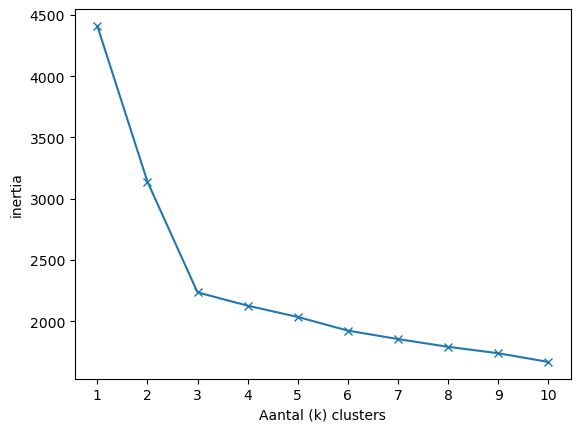

In [43]:
# Ignore the warning about KMeans memory leak
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Maken van inertia lijst en range voor k
inertia = []
k = range(1, 11)

# Loopen over het modelleren
for i in k:
    # Model aanmaken van K-Means
    model = KMeans(n_clusters=i, n_init=10)

    # Model fitten
    model.fit(scdf)

    # Intertia berekenen en toevoegen aan lijst
    inertia.append(model.inertia_)

# Plotten van de verschillende inertia
plt.plot(k, inertia, '-x')
plt.xlabel('Aantal (k) clusters')
plt.ylabel('inertia')
plt.xticks(k)
plt.show()

Zoals te zien is in de grafiek is het elleboog punt op k=3. Dit geeft aan dat het optimaal aantal cluster gelijk is aan 3. Minder clusters zal leiden tot een loss aan informatie, terwijl meer clusters zal leiden tot onduidelijke voorspellingen. Nu het aantal clusters bekent is kunnen we dit invoeren om een K-Means model te trainen en de clusters neer te zetten.

In [17]:
# Invoeren van aan clusters
k = 3

# Uitvoeren van K-Means om data te groeperen
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

# Clusters toevoegen aan dataframe
scdf['cluster'] = kmeans.fit_predict(scdf)

# Tonen van hoeveelheid in elk cluster
print(scdf['cluster'].value_counts())

0    40
2    39
1    26
Name: cluster, dtype: int64


Nu de clusters zijn toegevoegd aan de data is het tijd om te bepalen welke cluster behoort to welke genre muziek. Om dit te doen, moeten we eerst de cluster en de genres groeperen op de respectieve groepen. Dit zorgt ervoor dat we de gemiddelde kenmerken van elke groep kunnen vergelijken om te vinden welke groepen bij elkaar horen.

In [18]:
scdf_grouped = scdf.groupby('cluster').agg('mean')
scdf_grouped

,chroma10_mean,chroma11_mean,chroma12_mean,chroma1_mean,chroma2_mean,chroma3_mean,chroma4_mean,chroma5_mean,chroma6_mean,chroma7_mean,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.805091,-0.642518,-0.887135,-0.639054,-0.990153,-0.638103,-0.805533,-0.816092,-0.575058,-0.913843,...,-1.085846,-0.209926,1.114318,-0.506964,-0.312472,-0.164183,-0.663557,-0.483338,-0.670383,-0.341626
1,0.901895,0.675626,0.842572,0.515478,0.799336,0.734739,0.955260,1.061227,0.756281,0.659797,...,0.679839,0.162882,-0.374423,-0.767721,1.499267,-1.050988,1.426347,-0.812442,1.467305,-0.984872
2,0.224471,0.208575,0.348167,0.311787,0.482650,0.164639,0.189348,0.129533,0.085616,0.497410,...,0.660462,0.106721,-0.893275,1.031777,-0.679028,0.869051,-0.270327,1.037360,-0.290631,1.006967


In [19]:
sc_label = scaler(labeled)
sc_label['genre'] = labeled['genre']
scdfl = sc_label.groupby('genre').agg('mean')
scdfl = scdfl.drop('Hz', axis=1)
scdfl

C:\Users\crazy\AppData\Local\Temp\ipykernel_22280\2262526765.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scdfl = sc_label.groupby('genre').agg('mean')


,chroma10_mean,chroma11_mean,chroma12_mean,chroma1_mean,chroma2_mean,chroma3_mean,chroma4_mean,chroma5_mean,chroma6_mean,chroma7_mean,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
genre,,,,,,,,,,,,,,,,,,,,,
blues,-0.399163,0.640093,0.210312,-0.688562,-0.818185,-0.385168,-0.113333,-0.502574,-0.557908,-0.310915,...,-0.263798,-0.505011,0.918134,0.243213,0.556125,0.184839,0.188702,0.039634,0.233437,0.177360
classical,-1.390561,-1.395504,-1.104237,-0.656729,-0.979330,-0.838662,-1.436720,-0.304442,-0.958580,-0.983151,...,-1.532584,1.323335,1.129616,-0.713336,-0.805599,0.187766,-1.129266,-0.087103,-1.427242,0.067154
country,-0.188118,-0.684384,-0.200356,-0.435170,0.036547,-0.118004,-0.220891,0.192031,-0.589873,-0.268155,...,0.264289,-0.454321,0.290693,0.339520,0.307473,-0.060878,-0.226583,-0.192221,-0.180159,-0.517528
disco,-0.111627,0.123901,-0.283905,-0.069072,-0.000700,0.251043,0.211108,-0.045233,0.727298,0.463087,...,0.493680,-0.216592,-0.543266,0.305322,-0.784593,0.532762,-0.148738,0.742088,-0.372970,0.710443
hiphop,0.914914,0.907726,0.919442,1.174296,1.165403,0.715216,0.810143,1.042724,1.423973,0.995337,...,0.408264,0.260917,-0.543491,-0.585650,0.695698,-0.667020,1.422759,-0.765019,1.277316,-0.152469
jazz,-0.755918,-0.748595,-1.027452,-0.812692,-1.193408,-1.088327,-0.927903,-1.341634,-0.893706,-1.102479,...,-0.712067,-0.385368,0.634218,0.095933,0.260028,-0.483867,-0.147716,-0.247177,-0.249819,0.062708
metal,1.082052,0.797734,0.939248,0.720586,0.723744,0.686099,1.074738,1.132255,1.142239,1.202433,...,0.711583,0.318826,-0.433773,-0.932222,1.311821,-1.029750,1.069734,-0.735267,1.189815,-0.881726
pop,0.224796,0.366187,0.088577,0.469413,0.500708,0.352407,0.306501,-0.484584,0.068981,-0.244875,...,0.783727,-0.151191,-1.110466,0.967487,-1.477903,0.636546,-1.024685,0.956033,-0.852722,0.912750
reggae,0.128607,0.071620,0.501154,0.295111,0.315202,0.475614,0.224914,0.233787,0.255711,0.544826,...,-0.476479,0.378747,-0.205455,0.606452,-0.312523,0.886485,-0.179706,0.637009,0.191636,0.335474


## Cluster bepaling dmv afstand

In [20]:
def minkowski_distance(point1, point2, p):
    """
    Calculate the Minkowski distance between two points.

    :point1, point2: Numpy arrays or lists of coordinates of the two points.
    :p: Parameter used for Minkowski formula

    :returns the Minkowski distance
    """

    if not isinstance(point1, (list, np.ndarray)):
        point1 = [point1]
    if not isinstance(point2, (list, np.ndarray)):
        point2 = [point2]

    distance = [abs(a - b) ** p for a, b in zip(point1, point2)]
    minkowski = sum(distance) ** (1/p)
    return minkowski

def manhattan_distance(point1, point2):
    """
    Calculate the Manhattan distance between two points.

    :point1, point2: Numpy arrays or lists of coordinates of the two points.

    :returns the Manhattan distance
    """
    if not isinstance(point1, (list, np.ndarray)):
        point1 = [point1]
    if not isinstance(point2, (list, np.ndarray)):
        point2 = [point2]

    distance = [abs(a - b) for a, b in zip(point1, point2)]
    manhattan = sum(distance)

    return manhattan

def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    :point1, point2: Numpy arrays or lists of coordinates of the two points.

    :returns the Euclidean distance
    """
    if not isinstance(point1, (list, np.ndarray)):
        point1 = [point1]
    if not isinstance(point2, (list, np.ndarray)):
        point2 = [point2]

    distance = [abs(a - b) for a, b in zip(point1, point2)]
    euclidean = np.sqrt(sum(d ** 2 for d in distance))

    return euclidean

In [21]:
from collections import Counter

def bepaal_genres(afstand_func, *args):
    """
    Deze functie neemt een afstandsfunctie en bepaald de afstand van
    genre naar cluster. Dit gebeurt voor alle clusters en alle genres,
    het uiteindelijke antwoord is de meest voorkomende genre voor elk
    cluster.

    Parameters:
    ----------
    afstand_functie : func
        De afstands functie waarmee de afstand word berekend.

    Returns:
    ----------
    De meest voorkomende genre (de meeste kleine afstanden) per cluster
    """
    # Aanmaken dictionaries
    afstand_dfs = {}
    afstand = {}
    antwoorden = {}

    # For loop om dataframes te maken met afstanden
    for col in scdf_grouped.columns:
        # Aanmaken dataframe voor kolom met genres en clusters als index en kolom
        df_afstand = pd.DataFrame(index=scdf_grouped.index, columns=scdfl.index)
        for x, row1 in scdf_grouped.iterrows():
            for y, row2 in scdfl.iterrows():
                if args:
                    # Voor afstands functies met extra argumenten
                    df_afstand.at[x, y] = afstand_func(row1[col], row2[col], *args)
                else:
                    # Voor afstands functies met alleen a en b
                    df_afstand.at[x, y] = afstand_func(row1[col], row2[col])
        # Vullen van dict met feature afstanden
        afstand_dfs[col] = df_afstand

    # For loop voor kiezen juiste afstand
    for _, df_afstand in afstand_dfs.items():
        for i, row in df_afstand.iterrows():
            # Vinden van genre met kleinste afstand
            min_genre = min(row.items(), key=lambda x: x[1])[0]
            # Aanmaken key voor values als deze nog niet bestaat
            if i not in afstand:
                afstand[i] = []
            # Toevoegen kleinste genre afstand
            afstand[i].append(min_genre)

    # For loop om meest voorkomende genre te vinden
    for key, value in afstand.items():
        # Vinden van meest voorkomende genre
        genre = Counter(value).most_common(1)[0][0]

        # Toevoegen van meest voorkomende genre aan dict voor cluster
        antwoorden[key] = genre

    # Printen van de uitkomsten per cluster
    print(f"\nGenres volgens {afstand_func.__name__}:")
    for key, value in antwoorden.items():
        print(f"Cluster {key}: {value}")


# Kijken welke clusters tot welke genre horen
bepaal_genres(euclidean_distance)
bepaal_genres(manhattan_distance)
bepaal_genres(minkowski_distance, 2)


Genres volgens euclidean_distance:
Cluster 0: classical
Cluster 1: hiphop
Cluster 2: pop

Genres volgens manhattan_distance:
Cluster 0: classical
Cluster 1: hiphop
Cluster 2: pop

Genres volgens minkowski_distance:
Cluster 0: classical
Cluster 1: hiphop
Cluster 2: pop


## Cluster bepaling dmv grafieken

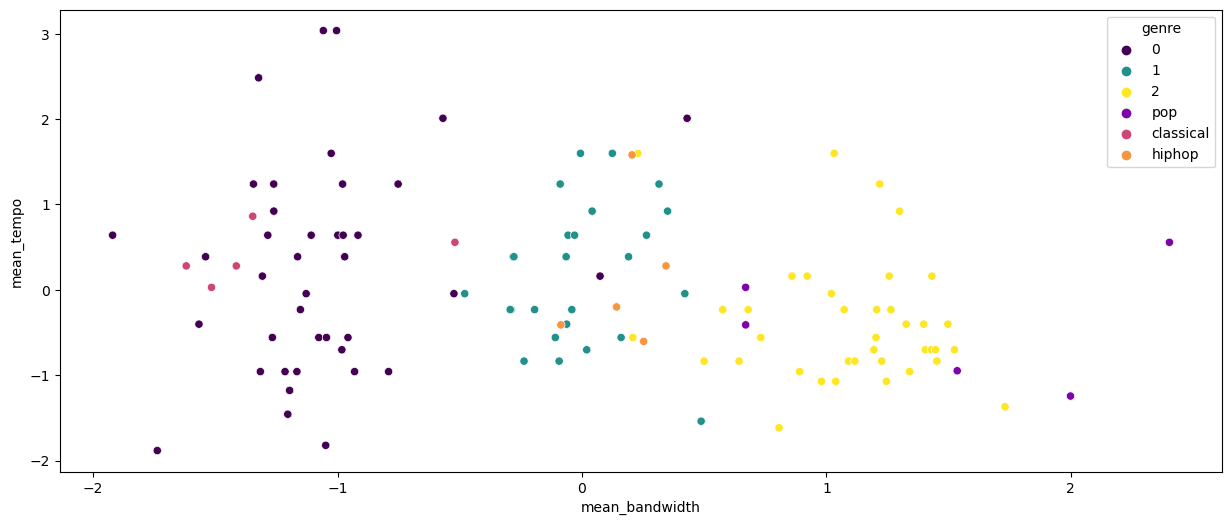

In [22]:
gcl = ['pop', 'hiphop', 'classical']

plt.figure(figsize=(15, 6))

sns.scatterplot(data=scdf,
                x='mean_bandwidth',
                y='mean_tempo',
                hue='cluster',
                palette='viridis')
sns.scatterplot(data=sc_label[sc_label['genre'].isin(gcl)],
                x='mean_bandwidth',
                y='mean_tempo',
                hue='genre',
                palette='plasma')
plt.show()

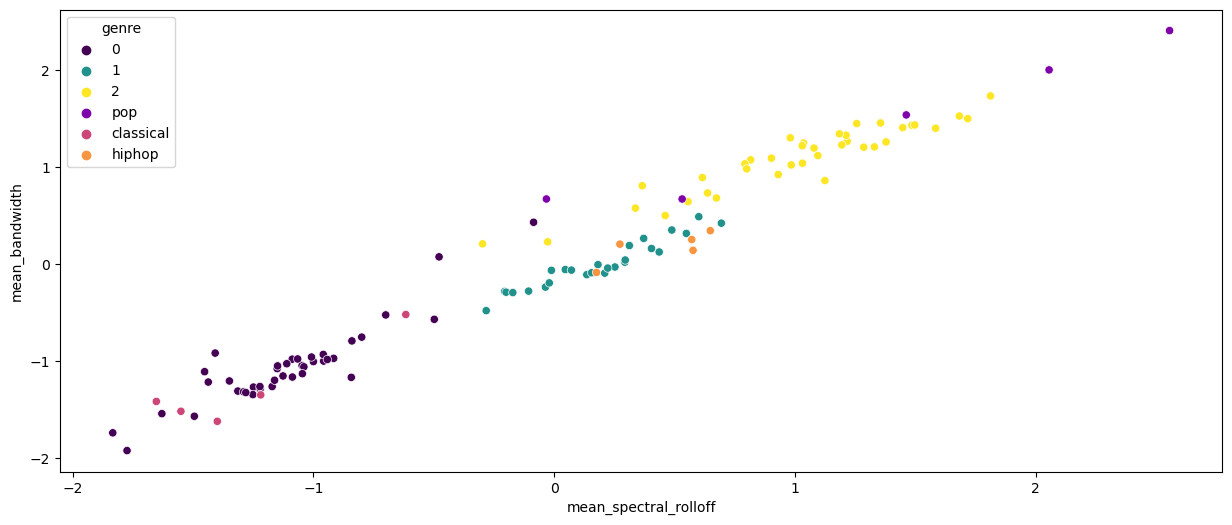

In [23]:
gcl = ['pop', 'hiphop', 'classical']

plt.figure(figsize=(15, 6))

sns.scatterplot(data=scdf,
                x='mean_spectral_rolloff',
                y='mean_bandwidth',
                hue='cluster',
                palette='viridis')
sns.scatterplot(data=sc_label[sc_label['genre'].isin(gcl)],
                x='mean_spectral_rolloff',
                y='mean_bandwidth',
                hue='genre',
                palette='plasma')
plt.show()

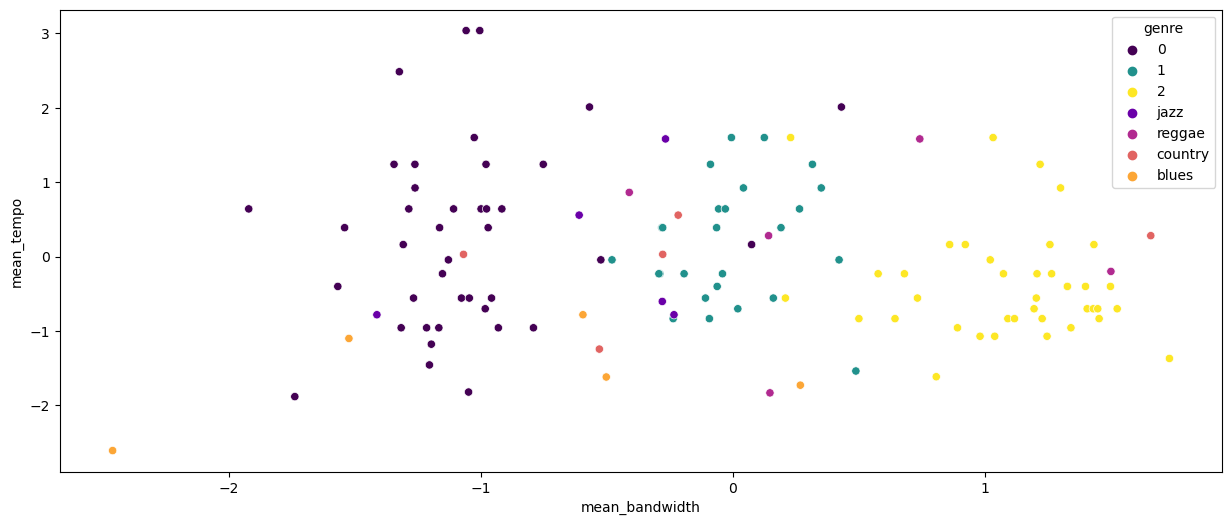

In [24]:
gcl = ['blues', 'country', 'reggae', 'jazz']

plt.figure(figsize=(15, 6))

sns.scatterplot(data=scdf,
                x='mean_bandwidth',
                y='mean_tempo',
                hue='cluster',
                palette='viridis')
sns.scatterplot(data=sc_label[sc_label['genre'].isin(gcl)],
                x='mean_bandwidth',
                y='mean_tempo',
                hue='genre',
                palette='plasma')
plt.show()

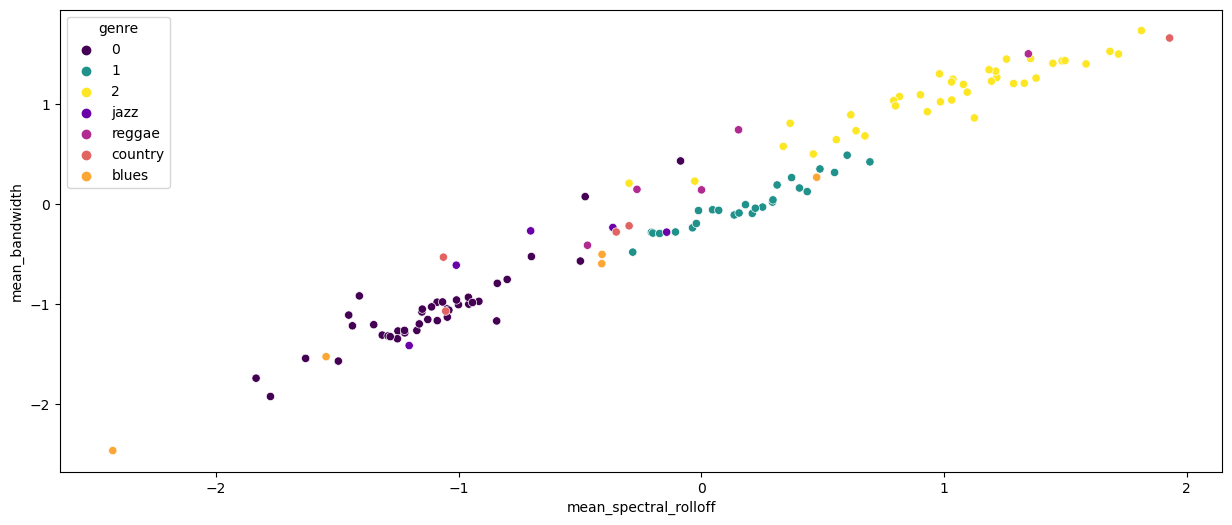

In [25]:
gcl = ['blues', 'country', 'reggae', 'jazz']

plt.figure(figsize=(15, 6))

sns.scatterplot(data=scdf,
                x='mean_spectral_rolloff',
                y='mean_bandwidth',
                hue='cluster',
                palette='viridis')
sns.scatterplot(data=sc_label[sc_label['genre'].isin(gcl)],
                x='mean_spectral_rolloff',
                y='mean_bandwidth',
                hue='genre',
                palette='plasma')
plt.show()

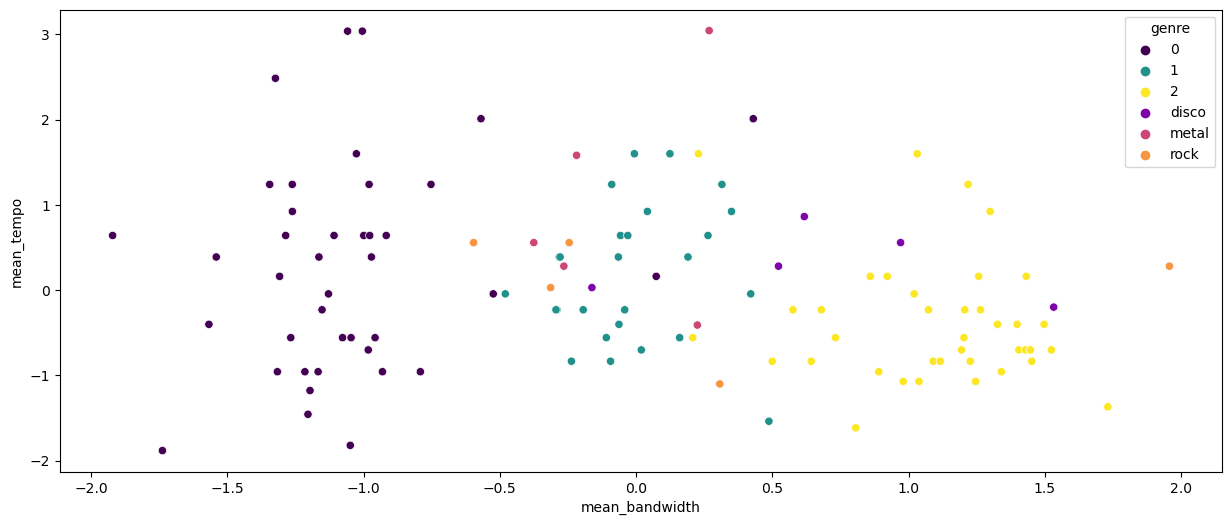

In [26]:
gcl = ['disco', 'metal', 'rock']

plt.figure(figsize=(15, 6))

sns.scatterplot(data=scdf,
                x='mean_bandwidth',
                y='mean_tempo',
                hue='cluster',
                palette='viridis')
sns.scatterplot(data=sc_label[sc_label['genre'].isin(gcl)],
                x='mean_bandwidth',
                y='mean_tempo',
                hue='genre',
                palette='plasma')
plt.show()

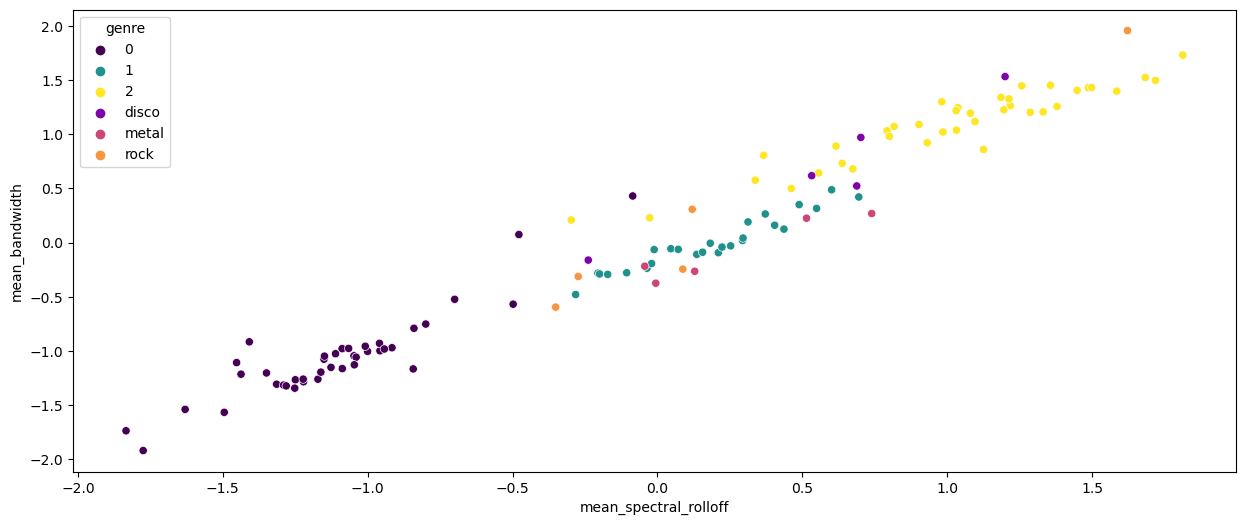

In [27]:
gcl = ['disco', 'metal', 'rock']

plt.figure(figsize=(15, 6))

sns.scatterplot(data=scdf,
                x='mean_spectral_rolloff',
                y='mean_bandwidth',
                hue='cluster',
                palette='viridis')
sns.scatterplot(data=sc_label[sc_label['genre'].isin(gcl)],
                x='mean_spectral_rolloff',
                y='mean_bandwidth',
                hue='genre',
                palette='plasma')
plt.show()

In [28]:
label = sc_label.drop(['Hz', 'data'], axis=1)
label.head()

,chroma10_mean,chroma11_mean,chroma12_mean,chroma1_mean,chroma2_mean,chroma3_mean,chroma4_mean,chroma5_mean,chroma6_mean,chroma7_mean,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
filename,,,,,,,,,,,,,,,,,,,,,
m00002.wav,-0.846840,-1.228802,-1.797462,-2.538675,-1.927595,-1.422201,-1.608868,-1.952736,-2.061946,-1.843063,...,-1.499082,-0.397462,0.463122,0.935166,-0.414782,-0.455867,0.173563,-0.548355,0.153848,-0.154394
m00039.wav,-0.774343,0.166656,0.148599,0.274586,-0.294009,-0.063082,-0.136101,-0.825063,-0.139499,-0.654388,...,-0.212582,0.563092,0.404405,0.230859,0.416474,0.080578,1.095720,-0.798675,0.182794,-0.490289
m00041.wav,-0.525240,0.323156,-0.824916,0.279415,1.374771,-0.779578,-0.062443,-1.138733,-0.202584,-0.829354,...,1.280696,0.712102,-1.004339,0.456144,-2.010779,0.114446,-1.459630,0.505158,-1.189411,0.923385
m00072.wav,-0.882787,-0.164225,-0.974522,-0.924657,0.004692,-0.991851,-0.125836,-0.808871,0.855741,1.321866,...,0.776830,1.333851,-0.581885,-0.145913,-1.929537,0.626036,-1.291822,0.739165,-0.678809,0.677718
m00096.wav,-1.158064,-1.125711,-0.605421,0.475153,-0.388660,-0.248243,-0.344288,-0.724991,-0.657160,-0.319173,...,0.555533,0.206802,-0.418231,0.535055,-0.098669,-1.324775,0.422015,-0.831156,0.605457,-0.993900


In [29]:
# Maken van dictionary voor vervangen cluster nummers
cluster_map = {
    0 : 'classical',
    1 : 'hiphop',
    2 : 'pop'
}

# Vervangen van de cluster nummers naar genres
scdf['cluster'] = scdf['cluster'].replace(cluster_map)
display(scdf['cluster'].head())

filename
m00003.wav       hiphop
m00012.wav       hiphop
m00013.wav    classical
m00043.wav       hiphop
m00044.wav    classical
Name: cluster, dtype: object

In [30]:
kaggle_df = pd.DataFrame(scdf['cluster'].reset_index())

kaggle_df

,filename,cluster
0,m00003.wav,hiphop
1,m00012.wav,hiphop
2,m00013.wav,classical
3,m00043.wav,hiphop
4,m00044.wav,classical
...,...,...
100,m00971.wav,classical
101,m00973.wav,pop
102,m00988.wav,pop
103,m00991.wav,classical


## **Bronnen**
<a href='https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040'>Singh, T. (2021, December 10). MFCC’s Made Easy - Tanveer Singh - medium. Medium.</a><br>
<a href='https://en.wikipedia.org/wiki/Mel-frequency_cepstrum'>Wikipedia contributors. (2023, November 13). Mel-frequency cepstrum. Wikipedia.</a><br>
<a href='https://brilliant.org/wiki/discrete-fourier-transform/'>Discrete Fourier Transform | Brilliant Math & Science Wiki. (n.d.).</a><br>
<a href='https://musicinformationretrieval.com/spectral_features.html'>spectral_features. (n.d.).</a><br>
<a href='https://ccrma.stanford.edu/~unjung/AIR/areaExam.pdf'>Nam, U. (2001, April 28). Special Area Exam Part II.</a><br>
<a href='https://librosa.org/doc/main/generated/librosa.feature.tonnetz.html'>librosa.feature.tonnetz — librosa 0.10.1 documentation. (n.d.).</a><br>
<a href='https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html'>librosa.feature.spectral_rolloff — librosa 0.10.1 documentation. (n.d.).</a><br>


In [31]:
test_file = "labeled/m00002.wav"
y, sr = lr.load(test_file, sr=None)

### Root Mean Square energy

De energie van muziek kan ook wel gedefinieerd worden als de intensiteit van de muziek. In praktische termen is dit de amplitude van de golf (?)(Ik breidt het wel uit en zoek er een bron bij)

Dit geeft ons een idee van de algemene intensiteit van een nummer. Theoretisch zou dit kunnen helpen met het onderscheiden tussen genres, een metal nummer zou over het algemeen intenser zijn dan een klassiek stuk. 

In [32]:
def rms_energy_features(data):
    # Compute RMS Energy
    rms_energy = lf.rms(y=data)

    return rms_energy

In [33]:
rms_energy_features(y)

array([[0.0464538 , 0.05530685, 0.06490424, ..., 0.03972533, 0.0372781 ,
        0.03184398]], dtype=float32)

### Chroma Feature

In muziektermen is de chroma feature gerelateerd aan de 12 toon klassen. Hiermee kunnen we een indicatie geven van de toonhoogtes van een muziekfragment. Dit hebben we gekozen omdate verschillende genres muziek over het algemeen ook verschillende tonen gebruiken.

In [34]:
def chroma_features(data, sfreq):
    # Compute Chroma feature
    chroma = lf.chroma_stft(y=data, sr=sfreq)

    datadict = {}

    # Fill datadict
    for var in range(len(chroma)):
        datadict[f'chroma{var + 1}_mean'] = np.mean(chroma[var, :])

    return datadict

In [35]:
chroma_features(y, sr)

{'chroma1_mean': 0.11765494,
 'chroma2_mean': 0.13391094,
 'chroma3_mean': 0.22048318,
 'chroma4_mean': 0.18841048,
 'chroma5_mean': 0.16817723,
 'chroma6_mean': 0.1936365,
 'chroma7_mean': 0.13062777,
 'chroma8_mean': 0.20394577,
 'chroma9_mean': 0.3643956,
 'chroma10_mean': 0.28758332,
 'chroma11_mean': 0.22447796,
 'chroma12_mean': 0.18569975}

### Zero Crossing Rate

De zero crossing rate houd in hoe vaak het (audio)signaal verandert van positief naar negatief of andersom. Hiermee is grofweg te zien hoeveel ruis er in een fragment zit. 

In [36]:
def zero_crossing_rate_features(data):
    # Compute Zero Crossing Rate (ZCR)
    zcr = lf.zero_crossing_rate(y=data)

    return zcr

In [37]:
zero_crossing_rate_features(y)

array([[0.02978516, 0.05078125, 0.06152344, ..., 0.04199219, 0.04736328,
        0.04003906]])

# Tempo

Tempo in de muziek verwijst naar de snelheid waarmee een muziekstuk wordt gespeeld. Het tempo wordt vaak afgedrukt in beats per minute (BPM). Hoe hoger het getal, hoe sneller de muziek is. 
- https://tweedehands-gitaar.nl/muziektheorie/begrippen/tempo
- https://librosa.org/doc/main/generated/librosa.beat.beat_track.html

In [38]:
# Analyzing tempo
#Using librosa's beat tracking functionality to estimate tempo
tempo, _ = librosa.beat.beat_track(y=data, sr=sfreq)

# Modifying tempo
#Time-stretching to change the tempo
y_stretched = librosa.effects.time_stretch(y=data, rate=1.5)

# Displaying the stretched waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y_stretched, sr=sfreq)
plt.title('Time-stretched Waveform')
plt.show()

# Play the time-stretched audio
ipd.Audio(y_stretched, rate=sfreq)


NameError: name 'data' is not defined

In [ ]:
#is een self defined functie nodig want he gebruikt hem eigenlijk maar 1x?


def calculate_tempo(audio_clips):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    
    tempo1 = []

    for clip in audio_clips:
        
        tempo, _ = librosa.beat.beat_track(y=clip, sr=sfreq)
        
        tempo1.append(tempo)

    return tempo1


In [ ]:
labeled['tempo'] = calculate_tempo(labeled['data'])
labeled

ParameterError: Audio data must be of type numpy.ndarray

# Beat

In [ ]:
def calculate_beat(audio_clips):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    
    beat = []

    for clip in audio_data:

        tempo, beats = librosa.beat.beat_track(y=clip, sr=sfreq)

        beat.append(beats)
    
    return beat

In [ ]:
beats = calculate_beat(audio_data)
df['beat'] = [np.mean(arr) for arr in beats]
df

,filename,genre,data,Hz,tempo,beat
0,m00002.wav,jazz,"[-0.016357421875, -0.0228271484375, -0.0146789...",22050,129.199219,451.600000
1,m00039.wav,reggae,"[-0.09478759765625, -0.15338134765625, -0.1439...",22050,135.999178,456.489796
2,m00041.wav,pop,"[0.078033447265625, -0.03765869140625, 0.12664...",22050,95.703125,435.687500
3,m00072.wav,disco,"[0.1060791015625, 0.0849609375, 0.062103271484...",22050,129.199219,458.111111
4,m00096.wav,disco,"[-0.03607177734375, -0.105682373046875, -0.201...",22050,123.046875,464.644444
5,m00102.wav,classical,"[0.007843017578125, 0.00726318359375, 0.005828...",22050,112.347147,464.875000
6,m00112.wav,reggae,"[-0.00262451171875, -0.003753662109375, -0.003...",22050,151.999081,461.351852
7,m00138.wav,reggae,"[-0.02630615234375, -0.028778076171875, -0.013...",22050,123.046875,465.044444
8,m00192.wav,classical,"[0.069671630859375, 0.065948486328125, 0.04238...",22050,129.199219,369.108108
9,m00206.wav,hiphop,"[-0.1112060546875, -0.198211669921875, -0.1393...",22050,112.347147,463.256410


# Harmonie

Harmonie in de muziek betekent dat verschillende tonen op hetzelfde moment worden gespeeld of gezongen. Uit de functie krijg je een audio tijdserie die de harmonische elementen laat zien.


Harmonie in de muziek betekent dat verschillende tonen op hetzelfde moment worden gespeeld of gezongen. Met behulp van de librosa.effects.hpss(y) functie kun je de harmonische elementen van een audiogolfvorm verkrijgen door de resulterende harmonische component (H) te analyseren.

- https://librosa.org/doc/main/generated/librosa.effects.hpss.html
- http://www.hoorn.be/muziektermen.htm


In [ ]:
def calculate_harmonie(audio_clips):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """


    harmonie = []

    for clip in audio_data:

        harmonic, _ = librosa.effects.hpss(y=clip)

        harmonie.append(harmonic)
        
    return harmonie


In [ ]:
harmonie = calculate_harmonie(audio_data)
df['harmonie'] = [np.mean(arr) for arr in harmonie]
df


,filename,genre,data,Hz,tempo,beat,harmonie
0,m00002.wav,jazz,"[-0.016357421875, -0.0228271484375, -0.0146789...",22050,129.199219,451.600000,8.802505e-05
1,m00039.wav,reggae,"[-0.09478759765625, -0.15338134765625, -0.1439...",22050,135.999178,456.489796,-1.920688e-03
2,m00041.wav,pop,"[0.078033447265625, -0.03765869140625, 0.12664...",22050,95.703125,435.687500,1.849548e-05
3,m00072.wav,disco,"[0.1060791015625, 0.0849609375, 0.062103271484...",22050,129.199219,458.111111,-3.913120e-06
4,m00096.wav,disco,"[-0.03607177734375, -0.105682373046875, -0.201...",22050,123.046875,464.644444,2.437503e-03
5,m00102.wav,classical,"[0.007843017578125, 0.00726318359375, 0.005828...",22050,112.347147,464.875000,-9.149655e-04
6,m00112.wav,reggae,"[-0.00262451171875, -0.003753662109375, -0.003...",22050,151.999081,461.351852,-3.358176e-03
7,m00138.wav,reggae,"[-0.02630615234375, -0.028778076171875, -0.013...",22050,123.046875,465.044444,1.119409e-05
8,m00192.wav,classical,"[0.069671630859375, 0.065948486328125, 0.04238...",22050,129.199219,369.108108,-5.814562e-04
9,m00206.wav,hiphop,"[-0.1112060546875, -0.198211669921875, -0.1393...",22050,112.347147,463.256410,-2.099915e-05


# PCA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df1 = df.copy()

df1 = df1.select_dtypes([np.number])
df1 = df1.dropna()
df1.head()

,Hz,tempo1,tempo
0,22050,129.199219,129.199219
1,22050,135.999178,135.999178
2,22050,95.703125,95.703125
3,22050,129.199219,129.199219
4,22050,123.046875,123.046875


In [ ]:
# Assuming 'datasubject' is the column you want to exclude from standardization
columns_to_standardize = df.columns.difference(['filename'])

# Separate the 'datasubject' column
datasubject_column = df['filename']
df_to_standardize = df[columns_to_standardize]

# Standardize the remaining columns
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_to_standardize), columns=columns_to_standardize)

# Combine 'datasubject' column with the standardized DataFrame
df3_standardized = pd.concat([datasubject_column, df_standardized], axis=1)

# Display the standardized DataFrame
df3_standardized.head()


ValueError: setting an array element with a sequence.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns = df1.columns

df1 = pd.DataFrame(scaler.fit_transform(df1.to_numpy()), columns=columns)

df1.head()

,Hz,tempo1,tempo
0,0.0,0.456344,0.456344
1,0.0,0.730097,0.730097
2,0.0,-0.892145,-0.892145
3,0.0,0.456344,0.456344
4,0.0,0.208662,0.208662


In [ ]:
cov_mat = df1.cov()

In [ ]:
eigenvals, eigenvecs = np.linalg.eig(cov_mat) 
print(f"The magnitudes of the projections are: {eigenvals}")
print(f"The vectors of the projections are: {eigenvecs}")

The magnitudes of the projections are: [2.04081633 0.         0.        ]
The vectors of the projections are: [[ 0.          0.          1.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.70710678 -0.70710678  0.        ]]


In [ ]:

inds = eigenvals.argsort()
eigenvecs = eigenvecs[inds[::-1]]
eigenvals = eigenvals[inds[::-1]]

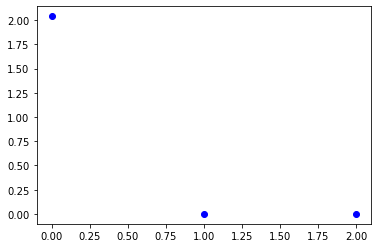

In [ ]:
plt.plot(eigenvals, 'bo')

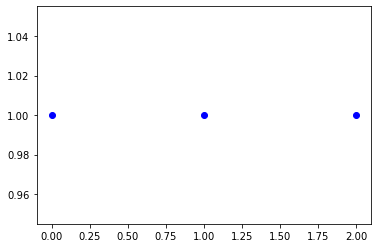

In [ ]:
plt.plot(np.cumsum(eigenvals) / sum(eigenvals), 'bo')



In [ ]:
PC = df1.to_numpy() @ eigenvecs


In [ ]:
PC = PC[:, :]
PC.shape

(50, 2)

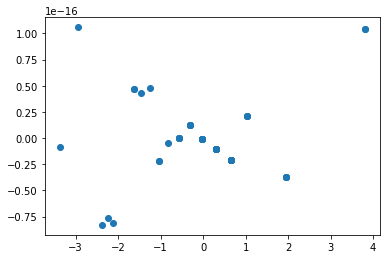

In [ ]:
plt.scatter(PC[:,0], PC[:,1])